In [1]:
import geohunter as gh
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

warnings.filterwarnings("ignore")

/Users/adelsondias/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
api = gh.osm.Eagle()

# Study area

[Natal, Brazil](https://en.wikipedia.org/wiki/Natal,_Rio_Grande_do_Norte)

Requesting name=Natal
Geohunter: [TIMELOG] get -- {'largest_geom': True, 'name': 'Natal'} -- Completed in 3.9285s


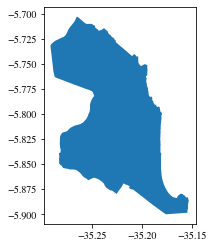

In [3]:
city = api.get('(-8.02, -41.01, -3.0, -33.0)',
                 largest_geom=True,
                 name='Natal')
city.plot();

# Grids

In [4]:
resolution = 1

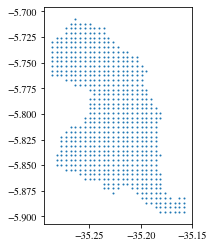

In [5]:
p_grid = gh.util.make_gridpoints(city, resolution=resolution/2)
p_grid = p_grid.drop(columns=['lat', 'lon'])
p_grid.plot(markersize=1);

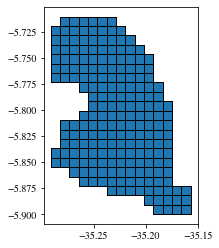

In [6]:
s_grid = gh.util.make_gridsquares(city, resolution)[['geometry']]
s_grid.plot(edgecolor='black')

# Extracting Points-of-Interest data

[OpenStreetMap's map features](https://wiki.openstreetmap.org/wiki/Map_Features)

Requesting amenity=school
Requesting amenity=hospital
Requesting amenity=restaurant
Requesting amenity=police
Requesting amenity=place_of_worship
Requesting leisure=*
Requesting highway=primary
Requesting highway=residential
Requesting highway=bus_stop
Requesting tourism=*
Requesting natural=sand
Requesting natural=wood
Requesting natural=beach
Requesting shop=*
Geohunter: [TIMELOG] get -- {'amenity': ['school', 'hospital', 'restaurant', 'police', 'place_of_worship'], 'leisure': '*', 'highway': ['primary', 'residential', 'bus_stop'], 'tourism': '*', 'natural': ['sand', 'wood', 'beach'], 'shop': '*'} -- Completed in 41.9194s


,type,id,tags,geometry,key,item,name
0,node,501170977,{'amenity': 'school'},POINT (-35.23427 -5.86902),amenity,school,NaN
1,node,501170997,"{'amenity': 'school', 'name': 'Centro de Atenç...",POINT (-35.22261 -5.82361),amenity,school,Centro de Atenção Integral a Criança e ao Adol...
2,node,501784871,{'amenity': 'school'},POINT (-35.21073 -5.81294),amenity,school,NaN
3,node,501784918,"{'amenity': 'school', 'name': 'Escola Boa Ideia'}",POINT (-35.22495 -5.87417),amenity,school,Escola Boa Ideia
4,node,502442042,{'amenity': 'school'},POINT (-35.23957 -5.84999),amenity,school,NaN


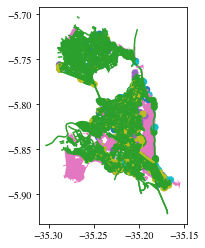

In [7]:
poi = api.get(city, 
    amenity=['school', 'hospital', 'restaurant', 'police', 'place_of_worship'],
    leisure='*',
    highway=['primary', 'residential', 'bus_stop'],
    tourism='*',      
    natural=['sand', 'wood', 'beach'],
    shop='*'
)
poi.loc[poi['key'].isin(['leisure', 'tourism', 'shop']), 'item'] = '*'
poi.plot(column='key')
poi.head()

In [8]:
poi.groupby(['key','item']).size()

key      item            
amenity  hospital              48
         place_of_worship     154
         police                39
         restaurant           246
         school               188
highway  bus_stop             417
         primary              661
         residential         8122
leisure  *                   1248
natural  beach                 16
         sand                  54
         wood                  49
shop     *                   1023
tourism  *                    190
dtype: int64

# Extracting geographic features/covariates

## 1. Quadrat method

In [9]:
x = []
for pair in poi[['key', 'item']].drop_duplicates().iterrows():
    key, item = pair[1].values
    x.append(gpd.sjoin(poi.loc[(poi['key']==key) & (poi['item']==item)], s_grid)\
            .groupby('index_right').size().to_frame(f'{key}_{item}'))
    
X_quadrat = pd.concat(x, axis=1)\
                    .join(s_grid, how='outer')\
                    .fillna(0)
X_quadrat = gpd.GeoDataFrame(X_quadrat)

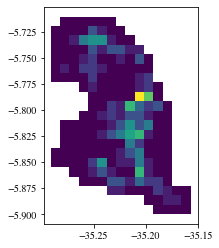

In [10]:
feature = 'amenity_school'
X_quadrat.plot(column=feature)

## 2. KDE method

In [11]:
area_sgrid = gpd.GeoDataFrame(geometry=[s_grid.geometry.unary_union])

In [12]:
x = []
for pair in poi[['key', 'item']].drop_duplicates().iterrows():
    key, item = pair[1].values
    x.append(gh.util.kde_interpolation(poi.loc[(poi['key']==key) & (poi['item']==item)], 
                                       bw='silverman', area=area_sgrid, resolution=resolution/2)['density']\
                                       .to_frame(f'{key}_{item}'))
X_kde = pd.concat(x, axis=1)
X_kde = p_grid.join(X_kde)

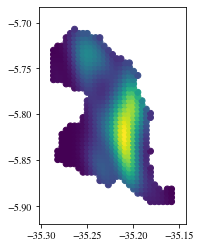

In [13]:
feature = 'amenity_school'
X_kde.plot(column=feature)

Average values within the square grid cells:

,amenity_school,amenity_hospital,amenity_restaurant,amenity_police,amenity_place_of_worship,leisure_*,highway_primary,highway_residential,highway_bus_stop,tourism_*,natural_sand,natural_wood,natural_beach,shop_*,geometry
5,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,"POLYGON ((-35.29124 -5.85499, -35.28225 -5.854..."
6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,"POLYGON ((-35.29124 -5.84595, -35.28225 -5.845..."
14,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,"POLYGON ((-35.29124 -5.77359, -35.28225 -5.773..."
15,4.92881,19.769322,0.001932,0.219579,30.528279,8.581472,1.231560,23.705884,0.000553,3.411960e-06,2.896084,0.352650,2.255496e-16,40.195054,"POLYGON ((-35.29124 -5.76455, -35.28225 -5.764..."
16,4.97659,17.154913,0.002760,0.414139,29.155735,9.678466,1.116768,45.058865,0.000543,2.940674e-07,1.810107,1.063615,2.040835e-16,34.654553,"POLYGON ((-35.29124 -5.75551, -35.28225 -5.755..."


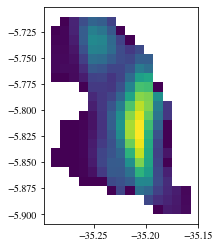

In [14]:
X_kde = gpd.sjoin(X_kde, s_grid)\
                .groupby('index_right').mean()\
                .join(s_grid, how='outer')\
                .fillna(0)
X_kde = gpd.GeoDataFrame(X_kde)
X_kde.plot(feature)
X_kde.head()

# Qualitative assessment

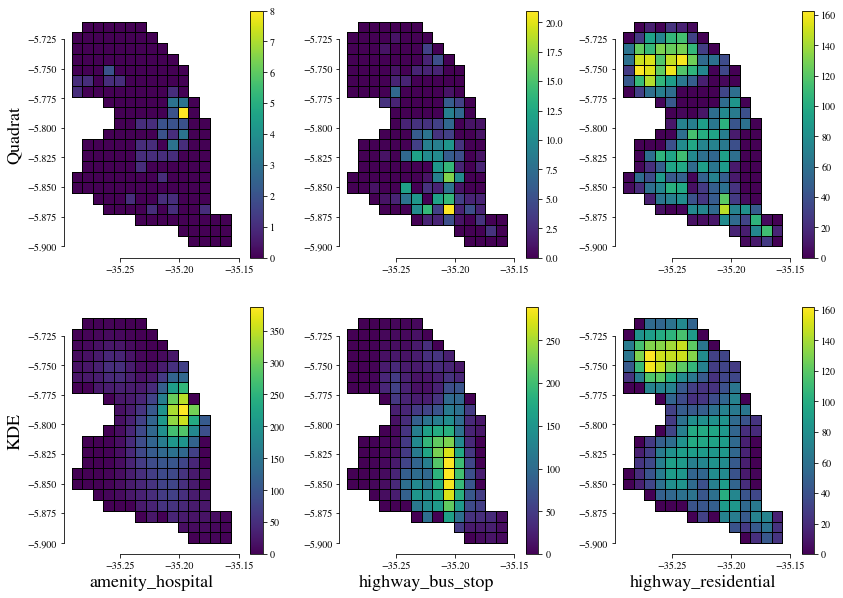

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,10))

for i in range(2):
    for j in range(3):
        s_grid.plot(edgecolor='black', color='white', ax=ax[i][j])

X_quadrat.plot(column='amenity_hospital', ax=ax[0][0], legend=True, edgecolor='black')
X_quadrat.plot(column='highway_bus_stop', ax=ax[0][1], legend=True, edgecolor='black')
X_quadrat.plot(column='highway_residential', ax=ax[0][2], legend=True, edgecolor='black')

X_kde.plot(column='amenity_hospital', ax=ax[1][0], legend=True, edgecolor='black')
X_kde.plot(column='highway_bus_stop', ax=ax[1][1], legend=True, edgecolor='black')
X_kde.plot(column='highway_residential', ax=ax[1][2], legend=True, edgecolor='black')

ax[0][0].set_ylabel('Quadrat', fontsize=18)
ax[1][0].set_ylabel('KDE', fontsize=18)

ax[1][0].set_xlabel('amenity_hospital', fontsize=18)
ax[1][1].set_xlabel('highway_bus_stop', fontsize=18)
ax[1][2].set_xlabel('highway_residential', fontsize=18)


sns.despine(trim=True)

fig.savefig('qualitative.pdf', dpi=200)

# Quantitaive assessment

Spatial heterogeneity (q) needs to use stratas on its calculation. We chose to get the city's neighborhoods as stratas.

Requesting admin_level=10
Geohunter: [TIMELOG] get -- {'admin_level': 10} -- Completed in 1.2462s


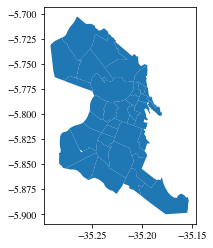

In [16]:
nhoods = api.get(city, admin_level=10)[['geometry', 'name']]
nhoods.plot();

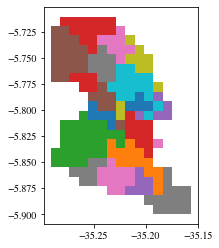

In [17]:
s_grid = s_grid.join(gpd.sjoin(s_grid, nhoods)['name'].to_frame('strata'))
s_grid = gpd.GeoDataFrame(s_grid).drop_duplicates(subset=['geometry'])
s_grid.plot(column='strata');

In [18]:
scores_quadrat, scores_kde = {}, {}
for feature in X_kde.drop(columns=['geometry']).columns:
    scores_kde[feature] = {'q':gh.util.q_ongrid(X_kde[feature], s_grid, strata_col='strata'),
                           'I':gh.util.moran_i_ongrid(X_kde[feature], 
                                                      s_grid['geometry'].centroid.apply(lambda x:x.coords[0]), 
                                                      d_threshold=resolution/110.5)[0]}

    scores_quadrat[feature] = {'q':gh.util.q_ongrid(X_quadrat[feature], s_grid, strata_col='strata'),
                               'I':gh.util.moran_i_ongrid(X_quadrat[feature], 
                                                          s_grid['geometry'].centroid.apply(lambda x:x.coords[0]), 
                                                          d_threshold=resolution/110.5)[0]}

In [19]:
scores_kde = scores_kde = pd.DataFrame(scores_kde).T.reset_index()\
                    .melt(value_vars=['q','I'], id_vars=['index'])\
                    .assign(Method='KDE')
scores_quadrat = pd.DataFrame(scores_quadrat).T.reset_index()\
                    .melt(value_vars=['q','I'], id_vars=['index'])\
                    .assign(Method='Quadrat')

scores = pd.concat([scores_quadrat, scores_kde]).rename(columns={'index':'feature'})

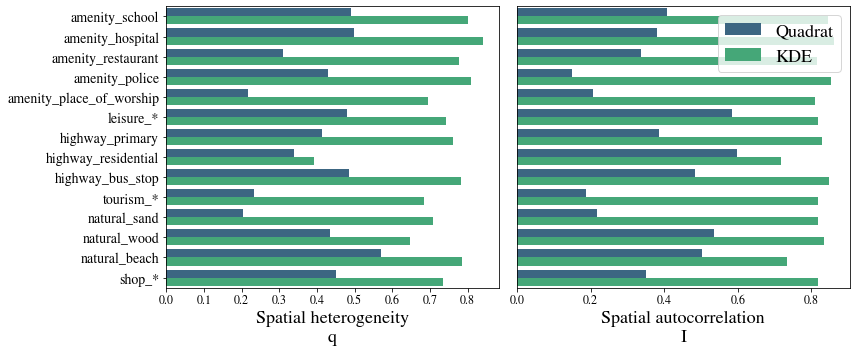

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
sns.barplot(y='feature', x='value', hue='Method', data=scores.loc[scores['variable']=='q'], ax=ax[0], palette='viridis')
sns.barplot(y='feature', x='value', hue='Method', data=scores.loc[scores['variable']=='I'], ax=ax[1], palette='viridis')


ax[0].yaxis.set_tick_params(labelsize=14)
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].set_ylabel('')
ax[0].set_xlabel('Spatial heterogeneity\nq', fontsize=18)
ax[0].get_legend().remove()

ax[1].legend(fontsize=18)
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].set_yticks([]) 
ax[1].set_ylabel('', fontsize=0)
ax[1].set_xlabel('Spatial autocorrelation\nI', fontsize=18)
fig.tight_layout()

fig.savefig('quantitative.pdf', dpi=200)